In [1]:
import os
import pandas as pd
import numpy as np
from nltools.data import Brain_Data
from nilearn.plotting import view_img
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation, two_sample_permutation
from nilearn import plotting, image
%matplotlib inline
from IPython.display import Image
import matplotlib.pyplot as plt

/Users/BerniceCheung/Documents/ResearchProject/DEV/DEV_RS/dev_rs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Primary research question

### Q1: Where do the neural representations of self-related traits fluctuate across contexts?

- Within which ROIs does same context correlations between neural RDMs > cross context correlations between neural RDMs

### Q1.5: Within those ROIs where the neural representations of self-related traits fluctuate, does the degree of the fluctuation tracks the degree of the differences in trait ratings across context?

- Within previously identified ROIs does the correlation between the neural RDMs from each context correlate with the average of absolute changes across all traits?

### Q2: Where do the neural representations of self-related traits reflect context specific self-evaluation (working self concepts)?

- Within which ROIs does the correlation between neural RDMs and rating RDMs in the friend context > those of the school context and vise versa

In [2]:
root_dir = "/Users/BerniceCheung/Dropbox (University of Oregon)/ResearchProject/socialContext"

# correlations of neuralRDMs between the two runs of a given context
sameCorr_friend =  pd.read_csv(os.path.join(root_dir, 'RSA', 'outputs', 'neuralRDM_sameCorr_ROI_friend.csv'), index_col=0)
sameCorr_school =  pd.read_csv(os.path.join(root_dir, 'RSA', 'outputs', 'neuralRDM_sameCorr_ROI_school.csv'), index_col=0)

# correlations of neuralRDMs between runs of each context
diffCorr_F1S2 = pd.read_csv(os.path.join(root_dir, 'RSA', 'outputs', 'neuralRDM_diffCorr_ROI_F1S2.csv'), index_col=0)
diffCorr_F2S1 = pd.read_csv(os.path.join(root_dir, 'RSA', 'outputs', 'neuralRDM_diffCorr_ROI_F2S1.csv'), index_col=0)

# RSA between the neuralRDMs and ratingRDMs of a given context
friend_RSA = pd.read_csv(os.path.join(root_dir, 'RSA', 'outputs', 'contextRSA_friend.csv'), index_col=0)
school_RSA = pd.read_csv(os.path.join(root_dir, 'RSA', 'outputs', 'contextRSA_school.csv'), index_col=0)

In [3]:
# load the whole brain parcellation mask
mask = Brain_Data(os.path.join(root_dir, 'brainMask', 'Neurosynth Parcellation', 'Neurosynth Parcellation_2.nii.gz'))

# get a list of ROIs
mask_x = expand_mask(mask)

# The association between event-related beta and self-ratings on traits

The purpose of this analysis is to check if the association between voxel activity and the present of a trait vary as a function of the self-rating of that trait across context.  

Procedure: 
1. reorder the event-related beta of a given run based on the reference trait order
2. concatenate the reordered event-related beta across 4 runs for each subject (64 * 4 = 256)
3. regress the beta on trait ratings across all subject
4. run a nonparametric 1-sample t-test with 5000 permutation using fsl randomise on the beta correlations 

In [3]:
# load the one-sample t-test results

beta_reg_ttest = Brain_Data(os.path.join(root_dir, 'RSA', 'beta_regression', 'outputs', 'beta_regress_oneSampT_tfce_corrp_tstat1.nii.gz'))


Output: screenshots of clusters of voxels that has a correlation > 0
1. vmPFC

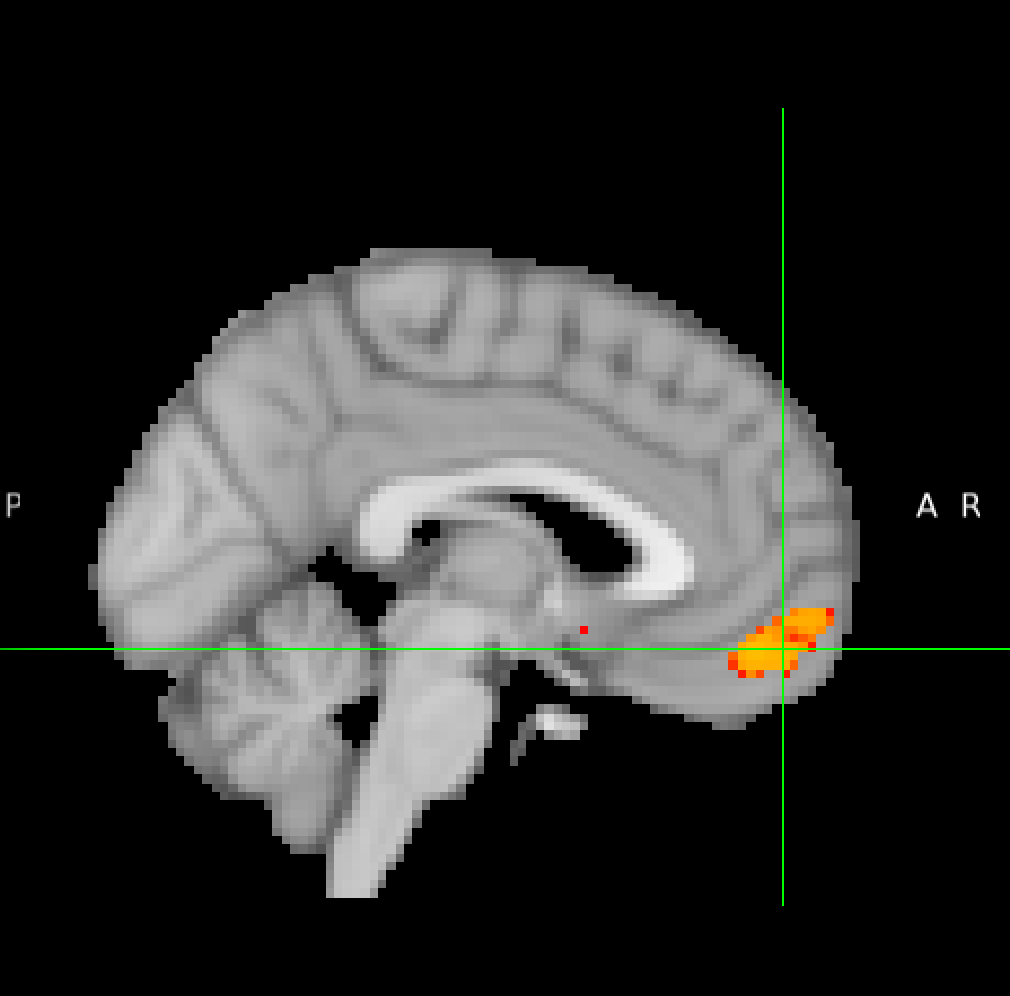

In [44]:

Image('/Users/BerniceCheung/Dropbox (University of Oregon)/ResearchProject/socialContext/RSA/reports/screenshots/beta_regress_vmpfc.png')

2. hippocampus

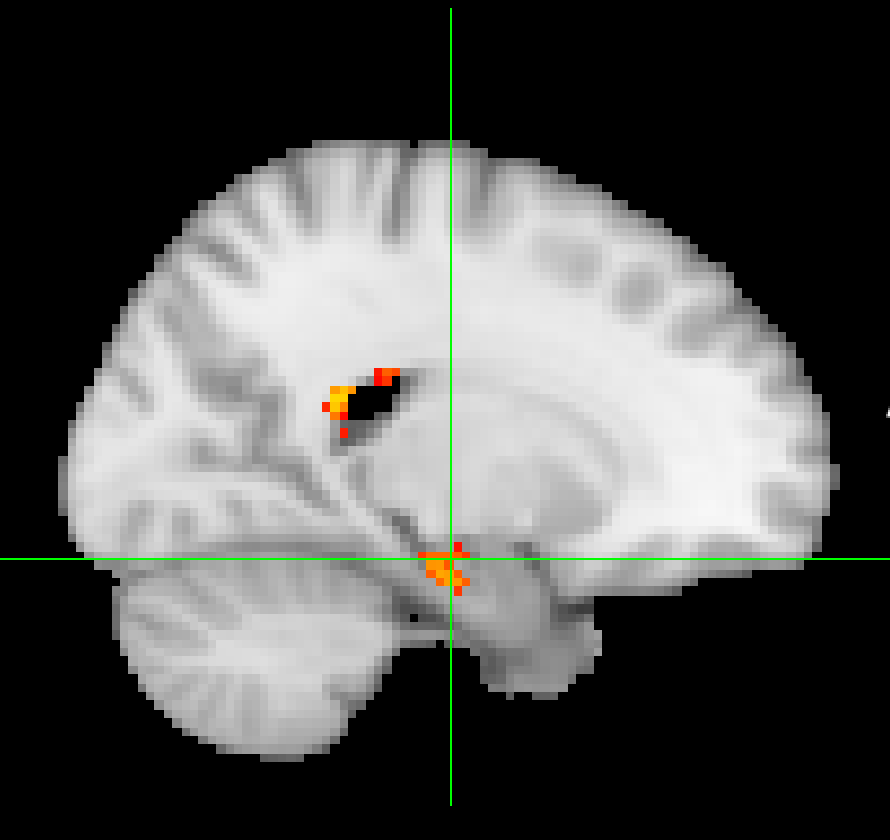

In [45]:
%matplotlib inline
from IPython.display import Image
Image('/Users/BerniceCheung/Dropbox (University of Oregon)/ResearchProject/socialContext/RSA/reports/screenshots/beta_regress_hippocampus.png')

# Same Context Neural RDM Correlations

Procedures for calculating same context Neural RDM correlation:  
1. Extracted beta from the first level GLM in which we regressed neural activity onto the onset of traits within each run  
2. For each run within each subject, rearrange the order of the betas to match with the order of reference trait list
3. a neural RDM for each run was generated by 1 - pair-wise correlation distance of beta. (this similarity index ranges from -1 to 1, higher means more similar)  
4. Same context correlation was generated for each context (friend run 1 was correlated with friend run 2; school run 1 was correlated with school run 1)  
5. Different context correlatoin was generated by correlating friend run 1 with school run 2 (F1S2) and friend run2 with school run 1 (F2S1)  
6. By contrasting same context correlation with different contract correalation, we can verify if and where do self-evaluation vary across context

## Friend context

Text(0.5, 0, 'Average within context correlation in friend context')

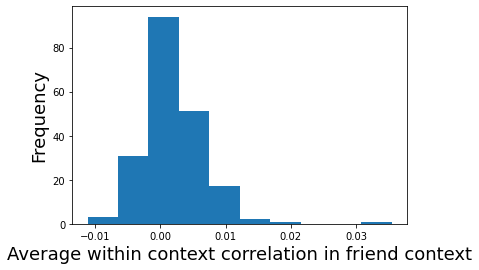

In [4]:
# generate the average Spearman correlation across all subject for each ROI
friend_corr_mean = sameCorr_friend.mean(axis = 0)

# plot a histogram of the corelations
plt.hist(friend_corr_mean)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Average within context correlation in friend context', fontsize=18)

In [5]:
friendCorr_1sample = []

for i in sameCorr_friend:
    friendCorr_1sample.append(one_sample_permutation(fisher_r_to_z(sameCorr_friend[i])))

In [13]:
friendCorr_1sample_df = pd.DataFrame(friendCorr_1sample)
friendCorr_1sample_df.to_csv(os.path.join(root_dir, 'RSA', 'outputs','friendCorr_1sample.csv'))

In [7]:
friendCorr_1sample_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, friendCorr_1sample)]).sum()
friendCorr_1sample_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, friendCorr_1sample)]).sum()

No ROI survived fdr corredcted p threshold

/Users/BerniceCheung/Documents/ResearchProject/DEV/DEV_RS/dev_rs_env/lib/python3.8/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


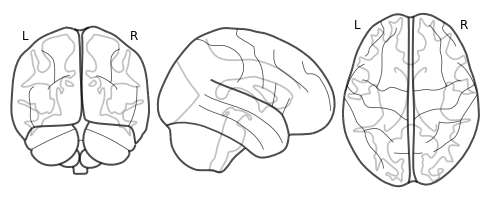

In [72]:
fdr_p = fdr(np.array([x['p'] for x in friendCorr_1sample]), q=0.05)
friendCorr_thresholded = threshold(friendCorr_1sample_r, friendCorr_1sample_p, thr=fdr_p)
friendCorr_thresholded_nifti = friendCorr_thresholded.to_nifti()
plotting.plot_glass_brain(friendCorr_thresholded_nifti, cmap='coolwarm')

ROIs that had a within-context correlation > 0 with a p-value threshold at 0.01 in the friend context

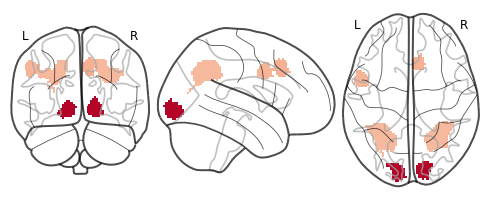

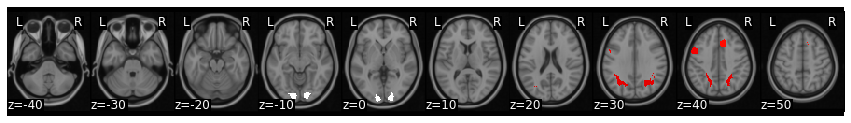

In [9]:
friendCorr_thresholded = threshold(friendCorr_1sample_r, friendCorr_1sample_p, thr=0.01)

friendCorr_thresholded_nifti = friendCorr_thresholded.to_nifti()
plotting.plot_glass_brain(friendCorr_thresholded_nifti, cmap='coolwarm')
friendCorr_thresholded.plot()
friendCorr_thresholded.write(os.path.join(root_dir, 'RSA', 'outputs', 'friend_sameCorr_001.nii.gz'))

In [ ]:
friendCorr_thresholded = threshold(friendCorr_1sample_r, friendCorr_1sample_p, thr=0.01)
friendCorr_thresholded_nifti = friendCorr_thresholded.to_nifti()
plotting.plot_glass_brain(friendCorr_thresholded_nifti, cmap='coolwarm')
friendCorr_thresholded.plot()
friendCorr_thresholded.write(os.path.join(root_dir, 'RSA', 'outputs', 'friend_sameCorr_001.nii.gz'))

## School Context

Text(0.5, 0, 'Average within context correlation in school context')

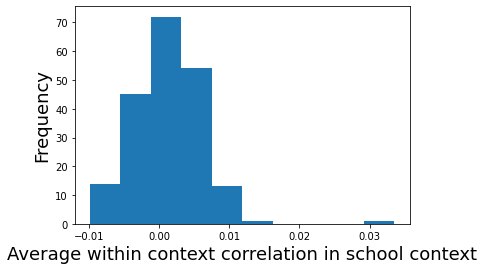

In [14]:
# generate the average Spearman correlation across all subject for each ROI
school_corr_mean = sameCorr_school.mean(axis = 0)

# plot a histogram of the corelations
plt.hist(school_corr_mean)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Average within context correlation in school context', fontsize=18)

In [15]:
schoolCorr_1sample = []

for i in sameCorr_school:
    schoolCorr_1sample.append(one_sample_permutation(fisher_r_to_z(sameCorr_school[i])))

In [16]:
schoolCorr_1sample_df = pd.DataFrame(schoolCorr_1sample)
schoolCorr_1sample_df.to_csv(os.path.join(root_dir, 'RSA', 'outputs','schoolCorr_1sample.csv'))

In [79]:
schoolCorr_1sample_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, schoolCorr_1sample)]).sum()
schoolCorr_1sample_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, schoolCorr_1sample)]).sum()

ROIs that had a within-context correlation > 0 with a p-value threshold at 0.01 in the school context

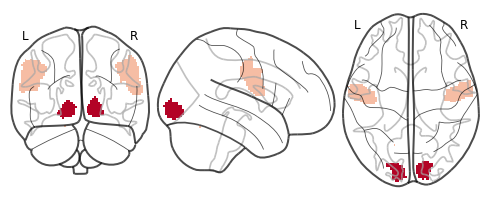

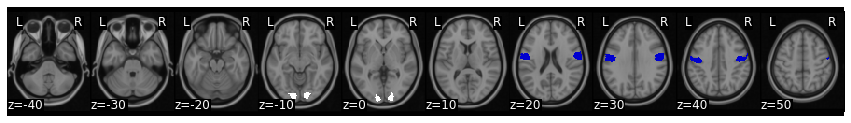

In [84]:
schoolCorr_thresholded = threshold(schoolCorr_1sample_r, schoolCorr_1sample_p, thr=0.01)
schoolCorr_thresholded_nifti = schoolCorr_thresholded.to_nifti()
plotting.plot_glass_brain(schoolCorr_thresholded_nifti, cmap='coolwarm')
schoolCorr_thresholded.plot()
schoolCorr_thresholded.write(os.path.join(root_dir, 'RSA', 'outputs', 'school_sameCorr_001.nii.gz'))

## Contrast between same context correlation and different context correlation

Contrast between average same context correlatoin and different context correlation for each ROIs. 

Procedure: 
1. average same context neural RDM = (sameCorr_friend + sameCorr_school) / 2
2. average different context neural RDM = (diffCorr_F1S2 + diffCorr_F2S1) / 2
3. subtract different context neural RDM from same context neural RDM, then transform to z score
4. conduct 1-sample t test against 0 with 5000 permutation

In [17]:
mean_sameCorr = (sameCorr_friend + sameCorr_school) / 2
mean_diffCorr = (diffCorr_F1S2 + diffCorr_F2S1) / 2

In [18]:
mean_same_diff_contr = []

for i, j in zip(sameCorr_friend, diffCorr_F1S2):
    mean_same_diff_contr.append(one_sample_permutation(fisher_r_to_z(mean_sameCorr[i]-mean_diffCorr[j])))

In [19]:
mean_same_diff_contr_df = pd.DataFrame(mean_same_diff_contr)
mean_same_diff_contr_df.to_csv(os.path.join(root_dir, 'RSA', 'outputs','mean_same_diff_contr.csv'))

In [91]:
mean_same_diff_contr_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, mean_same_diff_contr)]).sum()
mean_same_diff_contr_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, mean_same_diff_contr)]).sum()

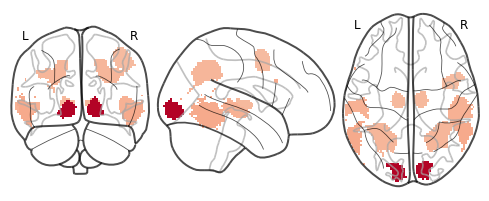

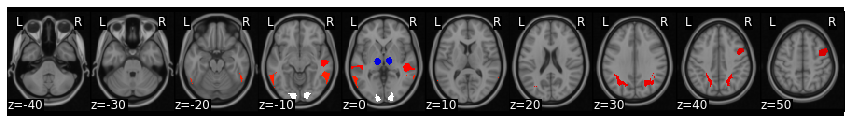

In [92]:
mean_same_diff_thresholded = threshold(mean_same_diff_contr_r, mean_same_diff_contr_p, thr=0.01)
mean_same_diff_thresholded_nifti = mean_same_diff_thresholded.to_nifti()
plotting.plot_glass_brain(mean_same_diff_thresholded_nifti, cmap='coolwarm')
mean_same_diff_thresholded.plot()
mean_same_diff_thresholded.write(os.path.join(root_dir, 'RSA', 'outputs', 'mean_same_diff_001.nii.gz'))

# Group Level Context RSA

1. For each context within each subject, the trait ratings were re-ordered based on the reference trait list(same as the order of the beta)  
2. Rating RDM for each context was generated by pair-wise substraction (trait raitng 1 - trait rating 2 )  
3. context RSA was generated by calculating the spearman rank correlation between the neural RDM from the first run of each context with the corresponding rating RDM

## Friend context RSA

In [20]:
# one sample permutation for friend context RSA
friend_RSA_1sample = []

for i in friend_RSA:
    friend_RSA_1sample.append(one_sample_permutation(fisher_r_to_z(friend_RSA[i])))

In [21]:
friend_RSA_1sample_df = pd.DataFrame(friend_RSA_1sample)
friend_RSA_1sample_df.to_csv(os.path.join(root_dir, 'RSA', 'outputs','friend_RSA_1sample.csv'))

In [94]:
# transform the permutated stats into an brain_data object
friend_RSA_1sample_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, friend_RSA_1sample)]).sum()
friend_RSA_1sample_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, friend_RSA_1sample)]).sum()

set threshold to 0.01

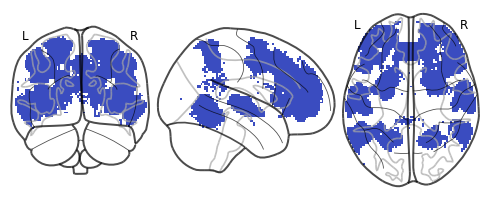

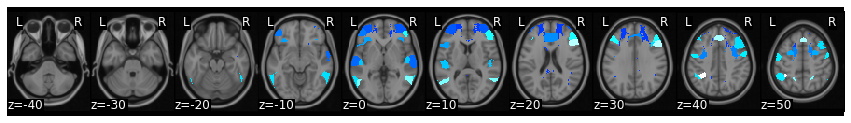

In [95]:
friend_RSA_thresholded = threshold(friend_RSA_1sample_r, friend_RSA_1sample_p, thr=0.01)
friend_RSA_thresholded_nifti = friend_RSA_thresholded.to_nifti()
plotting.plot_glass_brain(friend_RSA_thresholded_nifti, cmap='coolwarm')
friend_RSA_thresholded.plot()
friend_RSA_thresholded.write(os.path.join(root_dir, 'RSA', 'outputs', 'friend_RSA_001.nii.gz'))

set threshold to 0.005

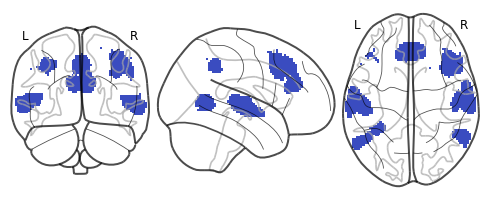

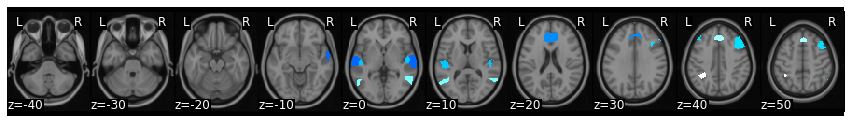

In [98]:
friend_RSA_thresholded = threshold(friend_RSA_1sample_r, friend_RSA_1sample_p, thr=0.005)
friend_RSA_thresholded_nifti = friend_RSA_thresholded.to_nifti()
plotting.plot_glass_brain(friend_RSA_thresholded_nifti, cmap='coolwarm')
friend_RSA_thresholded.plot()
friend_RSA_thresholded.write(os.path.join(root_dir, 'RSA', 'outputs', 'friend_RSA_005.nii.gz'))

## School context RSA

In [22]:
# one sample permutation for friend context RSA
school_RSA_1sample = []

for i in school_RSA:
    school_RSA_1sample.append(one_sample_permutation(fisher_r_to_z(school_RSA[i])))

In [23]:
school_RSA_1sample_df = pd.DataFrame(school_RSA_1sample)
school_RSA_1sample_df.to_csv(os.path.join(root_dir, 'RSA', 'outputs','school_RSA_1sample.csv'))

In [100]:
# transform the permutated stats into an brain_data object
school_RSA_1sample_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, school_RSA_1sample)]).sum()
school_RSA_1sample_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, school_RSA_1sample)]).sum()

/Users/BerniceCheung/Documents/ResearchProject/DEV/DEV_RS/dev_rs_env/lib/python3.8/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


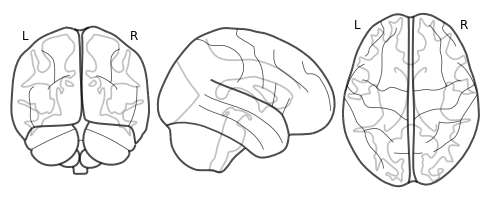

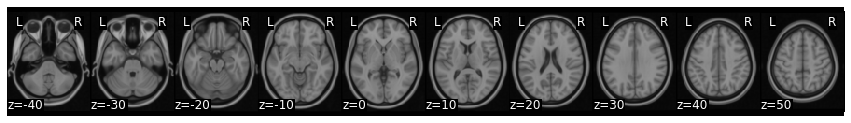

In [101]:
school_RSA_thresholded = threshold(school_RSA_1sample_r, school_RSA_1sample_p, thr=0.01)
friend_RSA_thresholded_nifti = school_RSA_thresholded.to_nifti()
plotting.plot_glass_brain(friend_RSA_thresholded_nifti, cmap='coolwarm')
school_RSA_thresholded.plot()
school_RSA_thresholded.write(os.path.join(root_dir, 'RSA', 'outputs', 'school_RSA_001.nii.gz'))